# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [20]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [21]:
data = pd.read_csv("baseCVs.csv")

In [22]:
data

,Total_Word_Count,Has_Photo,Has_Colors,Pages,Keyword_Count,Education_Exists,Education_Word_Count,Work_Experience_Exists,Work_Experience_Word_Count,Skills_Exists,...,Certifications_Word_Count,Achievements_Exists,Achievements_Word_Count,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed
0,499,1,1,2,26,1,40,1,384,1,...,0,0,0,1,57,0,0,0,0,1
1,794,1,1,2,25,0,0,1,4,0,...,0,0,0,1,9,1,424,0,0,0
2,351,1,1,2,13,1,30,1,97,1,...,22,0,0,0,0,0,0,0,0,0
3,566,1,1,3,20,1,34,1,35,1,...,28,0,0,0,0,1,82,0,0,0
4,1203,0,1,5,32,1,10,1,93,1,...,0,0,0,1,8,1,424,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,515,1,1,3,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
638,430,0,0,2,10,1,111,1,10,1,...,0,0,0,1,7,1,20,0,0,1
639,1203,0,0,8,60,1,24,1,46,1,...,28,1,30,1,10,1,424,0,0,0
640,528,1,1,4,25,0,0,1,397,1,...,0,0,0,1,16,0,0,0,0,1


### Descriptivo de la base

In [23]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Total_Word_Count                 642 non-null    int64
 1   Has_Photo                        642 non-null    int64
 2   Has_Colors                       642 non-null    int64
 3   Pages                            642 non-null    int64
 4   Keyword_Count                    642 non-null    int64
 5   Education_Exists                 642 non-null    int64
 6   Education_Word_Count             642 non-null    int64
 7   Work_Experience_Exists           642 non-null    int64
 8   Work_Experience_Word_Count       642 non-null    int64
 9   Skills_Exists                    642 non-null    int64
 10  Skills_Word_Count                642 non-null    int64
 11  Certifications_Exists            642 non-null    int64
 12  Certific

### División de la base en Train y Test

In [24]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (449, 22)
Forma de x_test: (193, 22)
Forma de y_train: (449,)
Forma de y: (193,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [26]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Precisión: 0.5544041450777202
Precisión: 0.3684210526315789
Recuperación: 0.08641975308641975
Puntuación F1: 0.14
AUC ROC: 0.451003086419753
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.57      0.89      0.70       112
           1       0.37      0.09      0.14        81

    accuracy                           0.55       193
   macro avg       0.47      0.49      0.42       193
weighted avg       0.49      0.55      0.46       193


Ranking de variables por importancia de Random Forest:
Keyword_Count                      0.164594
Total_Word_Count                   0.118989
Professional_Profile_Word_Count    0.103368
Work_Experience_Word_Count         0.101625
Education_Word_Count               0.101289
projects_Word_Count                0.082046
Skills_Word_Count                  0.080336
Pages                          

In [27]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
Has_Colors                         0.039378
projects_Word_Count                0.031792
volunteer_work_Exists              0.026995
Work_Experience_Exists             0.026315
Certifications_Exists              0.022646
Professional_Profile_Exists        0.017761
Professional_Profile_Word_Count    0.016221
Education_Word_Count               0.014721
Achievements_Exists                0.011055
Pages                              0.004519
Total_Word_Count                   0.000000
Projects_Exists                    0.000000
Achievements_Word_Count            0.000000
Skills_Word_Count                  0.000000
Certifications_Word_Count          0.000000
Has_Photo                          0.000000
Skills_Exists                      0.000000
Work_Experience_Word_Count         0.000000
Education_Exists                   0.000000
Keyword_Count                      0.000000
volunteer_work_Word_Count          0.000000
dtype: float64


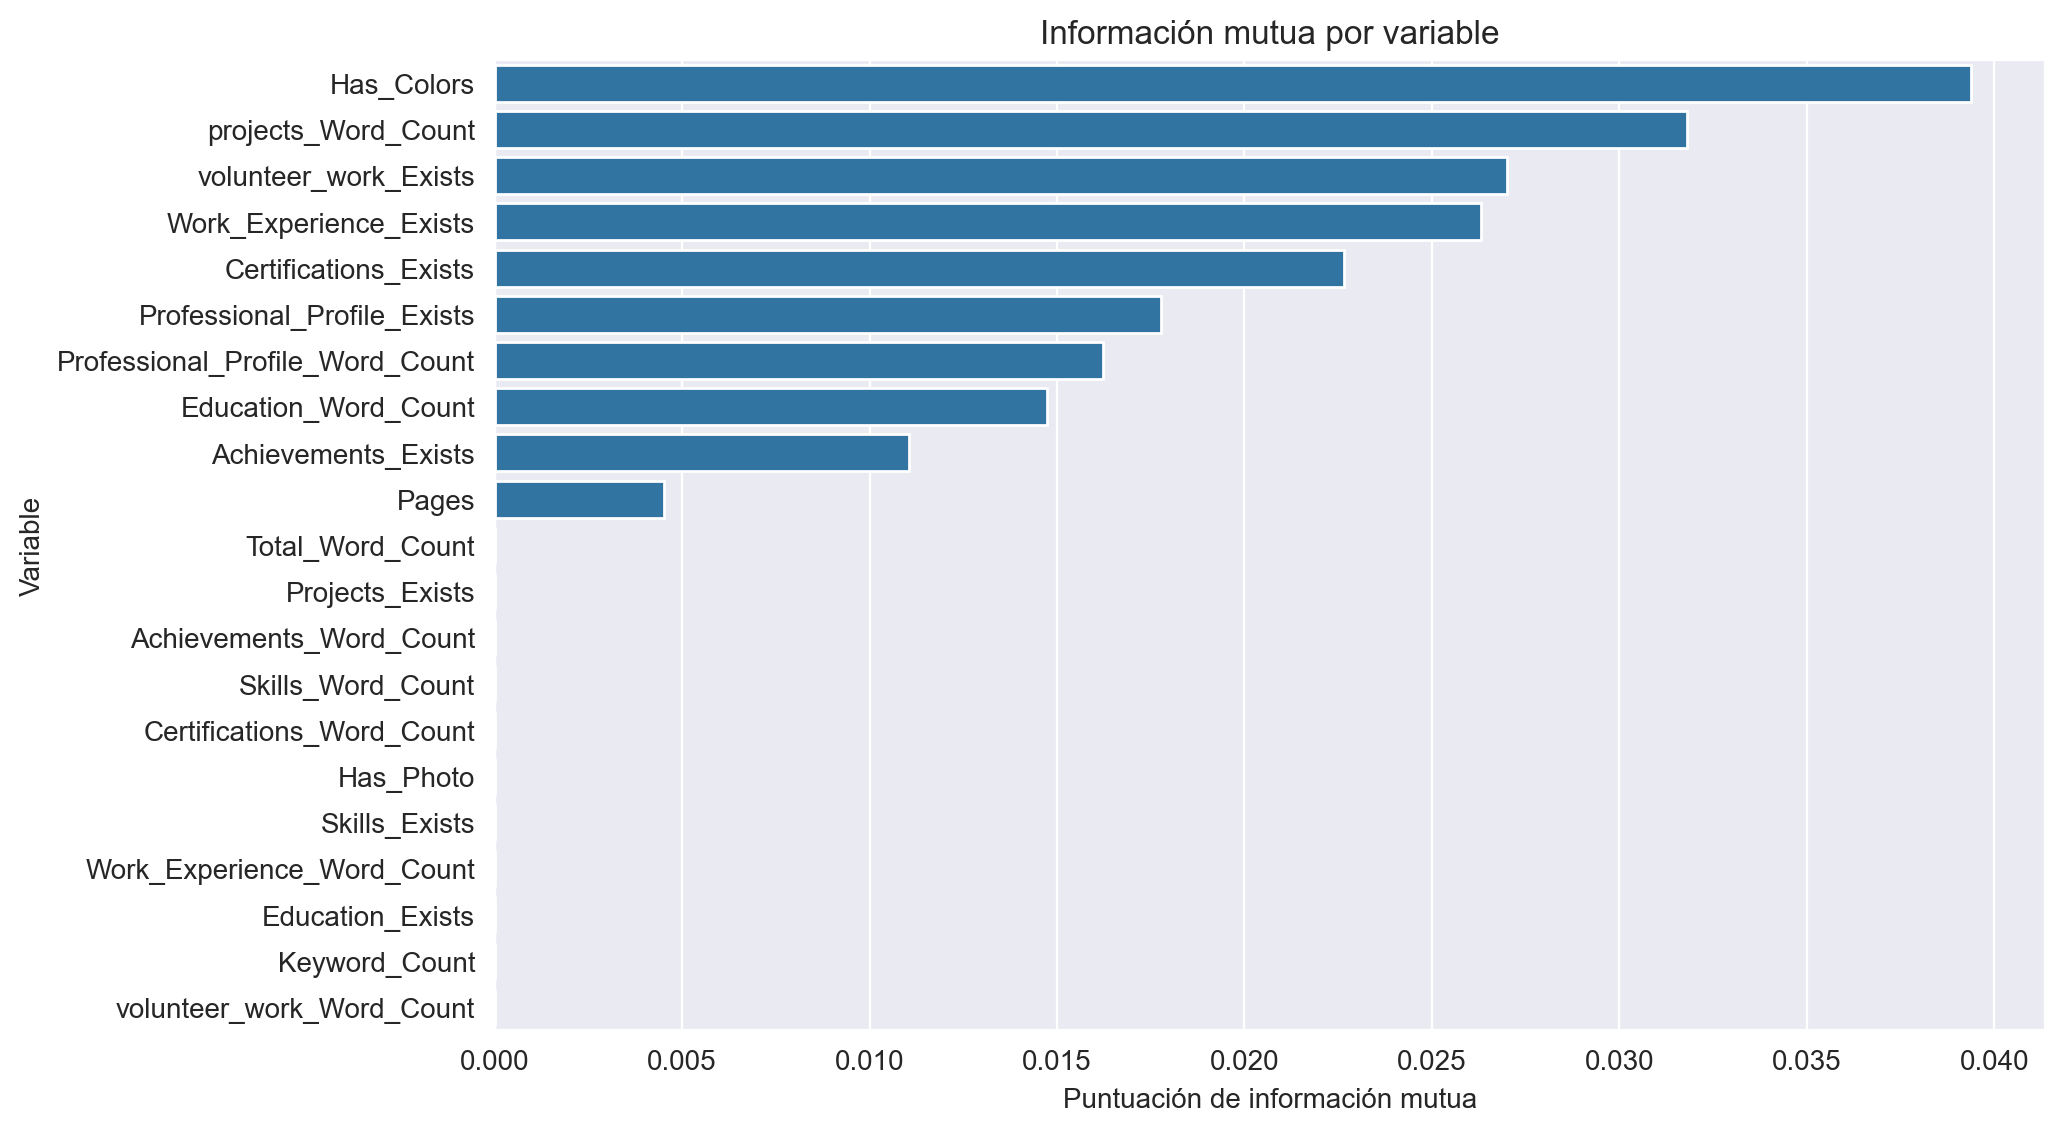

In [28]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [30]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 10, 'knn__weights': 'uniform'}
Precisión: 0.5544041450777202
Precisión: 0.42857142857142855
Recuperación: 0.18518518518518517
Puntuación F1: 0.25862068965517243
AUC ROC: 0.4793320105820105
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.58      0.82      0.68       112
           1       0.43      0.19      0.26        81

    accuracy                           0.55       193
   macro avg       0.51      0.50      0.47       193
weighted avg       0.52      0.55      0.50       193

Acierto en el conjunto de entrenamiento: 65.48(%)
Acierto en el conjunto de test: 55.44(%)
Variables seleccionadas: Index(['Has_Colors', 'Pages', 'Keyword_Count', 'Skills_Exists',
       'Certifications_Exists', 'Professional_Profile_Word_Count',
       'Projects_Exists', 'projects_Word_Count', 'volunteer_work_Exists',
       'volunteer_work_Word_Count'],
      dtype='object')
Resultado

## Agregar variables al modelo


In [31]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['projects_Word_Count', 'Work_Experience_Exists', 'Projects_Exists', 'Professional_Profile_Exists', 'volunteer_work_Word_Count', 'volunteer_work_Exists', 'Work_Experience_Word_Count', 'Achievements_Word_Count', 'Certifications_Word_Count', 'Total_Word_Count', 'Skills_Exists', 'Education_Exists', 'Has_Colors', 'Achievements_Exists', 'Certifications_Exists', 'Has_Photo', 'Pages', 'Professional_Profile_Word_Count', 'Skills_Word_Count', 'Education_Word_Count', 'Keyword_Count']


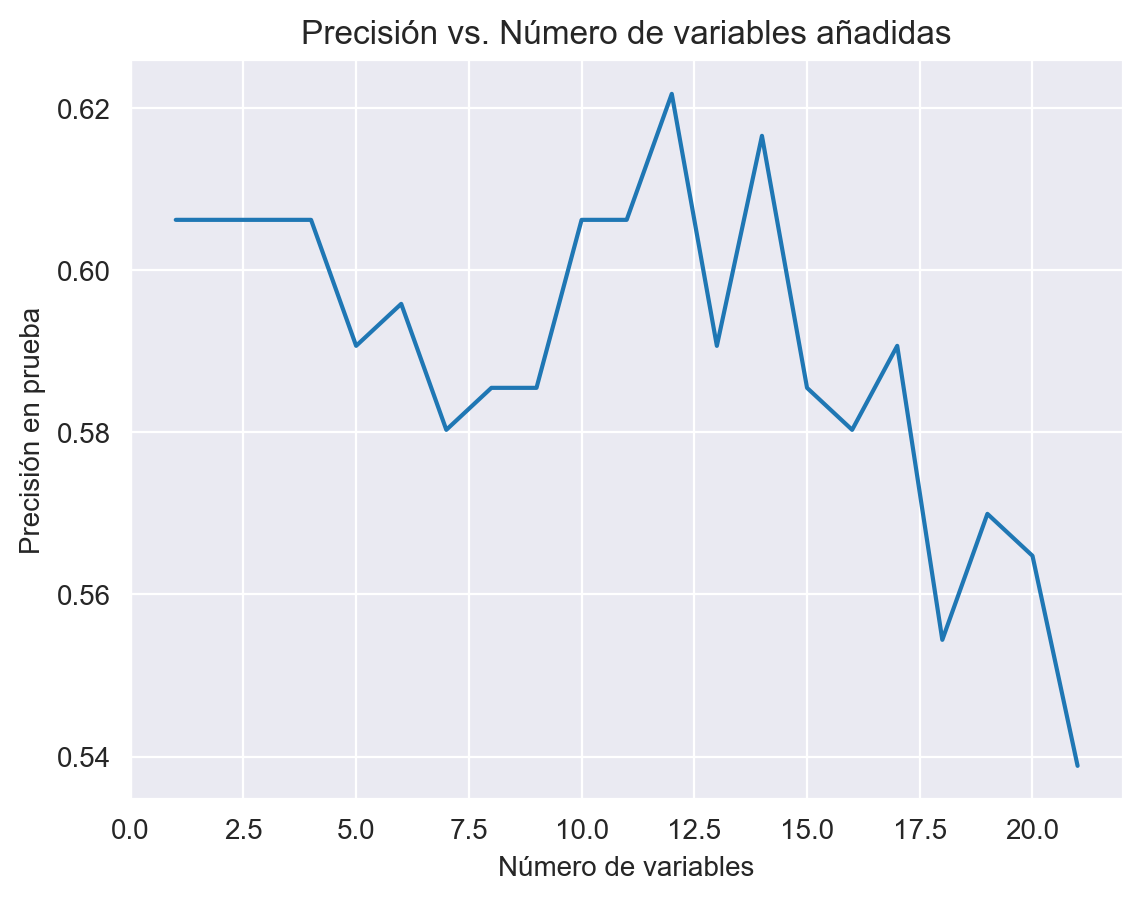

In [32]:
orden_vars, precisiones = agregar_variables_recursivamente(data)


Eliminar Variables del modelo

In [33]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Work_Experience_Exists', 'Skills_Exists', 'Projects_Exists', 'Total_Word_Count', 'volunteer_work_Exists', 'Certifications_Word_Count', 'volunteer_work_Word_Count', 'Certifications_Exists', 'Has_Photo', 'Skills_Word_Count', 'Achievements_Exists', 'Education_Exists', 'Achievements_Word_Count', 'projects_Word_Count', 'Keyword_Count', 'Has_Colors', 'Professional_Profile_Word_Count', 'Work_Experience_Word_Count', 'Professional_Profile_Exists', 'Education_Word_Count']


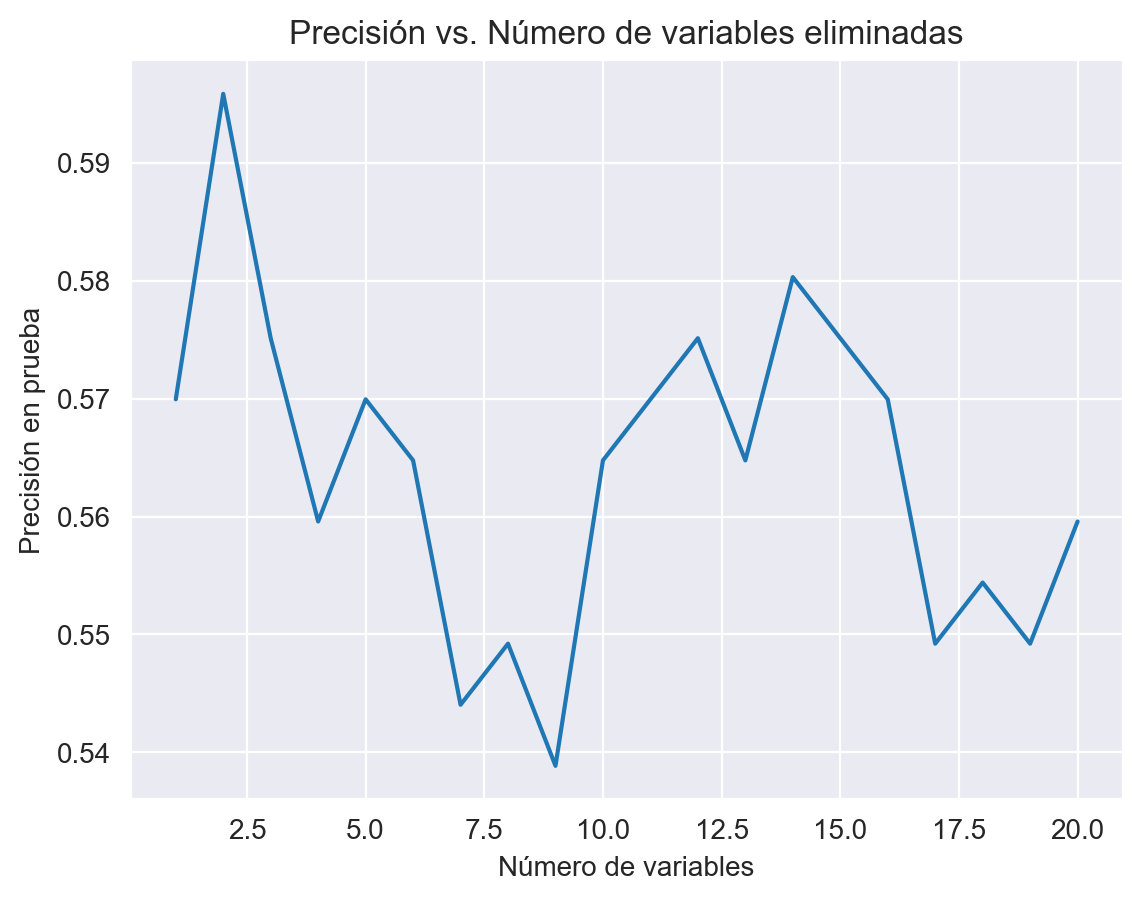

In [34]:
orden_vars, precisiones = eliminar_variables_recursivamente(data)

## Ranking de variables

In [35]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
Total_Word_Count                   0.135654
Keyword_Count                      0.132820
Work_Experience_Word_Count         0.115714
Education_Word_Count               0.107259
Skills_Word_Count                  0.102317
projects_Word_Count                0.082866
Professional_Profile_Word_Count    0.070380
Pages                              0.068049
Has_Colors                         0.024839
Certifications_Word_Count          0.021862
Has_Photo                          0.021515
Skills_Exists                      0.015920
Projects_Exists                    0.015773
Professional_Profile_Exists        0.015471
Education_Exists                   0.013537
Achievements_Word_Count            0.013033
Certifications_Exists              0.012412
volunteer_work_Word_Count          0.010193
Achievements_Exists                0.008961
volunteer_work_Exists              0.007727
Work_Experience_Exists             0.003697
dtype: float64


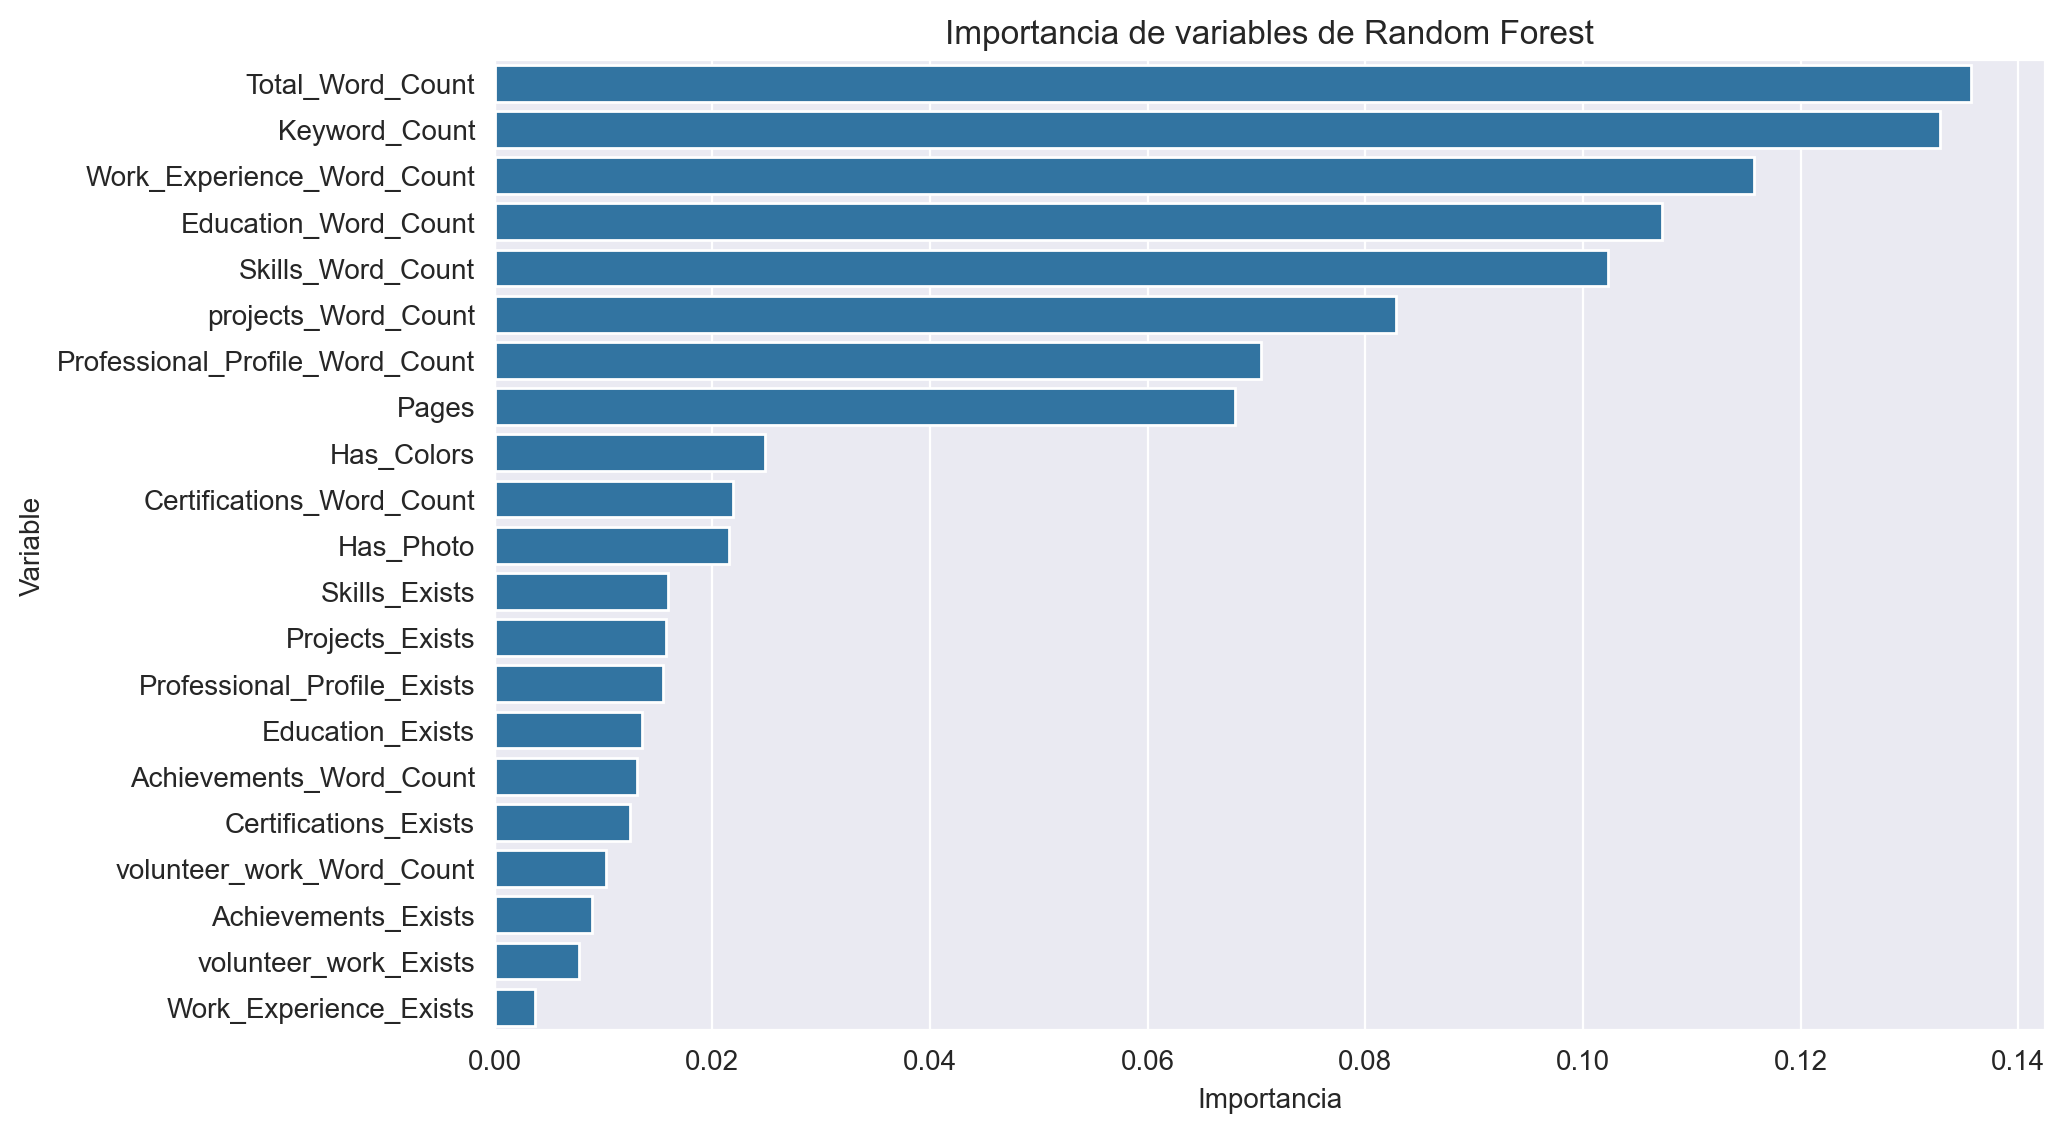

In [36]:
importancia_rf = obtener_importancia_rf(data)

# prueba con nuevo script ajustando muestra


In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 📌 Step 1: Load the dataset
df = pd.read_csv("baseCVs.csv")

# 📌 Step 2: Define features & target variable
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

# 📌 Step 3: Remove low-importance features
low_importance_features = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count", "Has_Photo"]
X = X.drop(columns=low_importance_features)

# 📌 Step 4: Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Step 5: Handle Class Imbalance
# Choose between SMOTE (Oversampling) or Undersampling
use_smote = True  # Change to False to use undersampling instead

if use_smote:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_train, y_train = undersample.fit_resample(X_train, y_train)

# 📌 Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [500, 700, 1000],  # Number of trees
    "max_depth": [5, 10, 15],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 3, 5],  # Min samples per leaf
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Step 7: Train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 📌 Step 8: Evaluate the model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# 📌 Step 9: Print Metrics
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 10: Cross-Validation for Stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Step 11: Feature Importance Ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
🔹 AUC-ROC Score: 0.4335802469135802

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.64      0.58        75
           1       0.29      0.20      0.24        54

    accuracy                           0.46       129
   macro avg       0.41      0.42      0.41       129
weighted avg       0.43      0.46      0.44       129


🔹 Cross-Validation F1 Score: 0.5645070808387045

🔹 Feature Importance:
 Total_Word_Count                   0.131697
Work_Experience_Word_Count         0.127726
Keyword_Count                      0.122666
Education_Word_Count               0.116223
Skills_Word_Count                  0.109286
Professional_Profile_Word_Count    0.090199
projects_Word_Count                0.084269
Pages                              0.059924
Certifications_Word_Count          0.030370
Professional_Profile_Exists    

### El modelo no funcionó bien con random forest, necesita ajuste.

Intentaremos con xGBoost

In [38]:
import xgboost as xgb
from imblearn.combine import SMOTEENN

# Remove non-numeric columns
if "CV_Name" in df.columns:
    df = df.drop(columns=["CV_Name"])

if "CV_Type" in df.columns:
    df = df.drop(columns=["CV_Type"])

# 📌 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Apply SMOTEENN to balance classes
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# 📌 Train Optimized XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=700,  # More trees for stability
    max_depth=4,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate improves generalization
    subsample=0.6,  # Prevent overfitting
    colsample_bytree=0.8,  # Keep feature diversity
    min_child_weight=3,  # Prevents small splits
    scale_pos_weight=4,  # Adjust class balance
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Evaluate model
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Cross-validation for stability
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 AUC-ROC Score: 0.5044444444444445

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.41      0.49        75
           1       0.44      0.63      0.52        54

    accuracy                           0.50       129
   macro avg       0.52      0.52      0.50       129
weighted avg       0.54      0.50      0.50       129


🔹 Cross-Validation F1 Score: 0.7249082125603865

🔹 Feature Importance:
 Professional_Profile_Word_Count    0.098734
Education_Exists                   0.098642
Work_Experience_Word_Count         0.089461
Pages                              0.089026
Total_Word_Count                   0.088494
Professional_Profile_Exists        0.087389
Skills_Word_Count                  0.086575
Education_Word_Count               0.082087
Projects_Exists                    0.078678
projects_Word_Count                0.074368
Skills_Exists                      0.063422
Keyword_Count                      0.063125
Work_Exp